# library importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import entropy, wasserstein_distance, spearmanr
from scipy.spatial.distance import jensenshannon
from typing import Tuple, Dict, Any, Union, Optional, List
import plotly.graph_objects as go

# Specify the path to our custom importer
import sys
sys.path.append('..')
from custom_imputer import KZImputer

# sets for graphics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
seed_value = 42

# definition of additional functions

In [2]:

def evaluate_metrics(
    imputed_series: np.ndarray,
    gap_info: Dict[str, Union[np.ndarray, Dict[int, float]]],
    full_checking_flag: bool = False
) -> Dict[str, float]:
    """
    Assessing the quality of gap recovery.

    Parameters:
    - imputed_series: np.ndarray — recovered series with gaps.
    - gap_info: dict containing:
    - 'missing_indices': np.ndarray(bool) — gap mask.
    - 'true_values': dict {index: value} — values ​​before zeroing.
    - full_checking_flag: bool — whether to compare recovery for the entire series (True), or only for missing points (False).

    Returns:
    - dict with MAE, RMSE, MAPE, R², NRMSE, JS divergence, Wasserstein distance, Correlation diff metrics.
    """
    missing_indices = gap_info['missing_indices']
    true_values_dict = gap_info['true_values']

    if full_checking_flag:
        full_true = imputed_series.copy()
        for i, val in true_values_dict.items():
            full_true.iloc[i] = val
        true_values = full_true.values
        imputed_values = imputed_series.values
    else:
        indices = list(true_values_dict.keys())
        true_values = np.array([true_values_dict[i] for i in indices])
        imputed_values = np.array([imputed_series.iloc[i] for i in indices])

    # del all NaN positions
    valid_mask = ~np.isnan(true_values) & ~np.isnan(imputed_values)
    true_values = true_values[valid_mask]
    imputed_values = imputed_values[valid_mask]

    # If there are no valid pairs left, return NaN metrics
    if len(true_values) == 0:
        return {
            "MAE": np.nan,
            "RMSE": np.nan,
            "MAPE": np.nan,
            "R2": np.nan,
            "NRMSE": np.nan,
            "JS_Divergence": np.nan,
            "Wasserstein": np.nan,
            "Correlation_Diff": np.nan,
        }

    # Metrics for missing or complete data
    mae = mean_absolute_error(true_values, imputed_values)
    rmse = np.sqrt(mean_squared_error(true_values, imputed_values))

    mask = np.abs(true_values) > 1e-2
    mape = np.mean(np.abs((true_values[mask] - imputed_values[mask]) / true_values[mask])) * 100 if np.any(mask) else np.nan
    r2 = r2_score(true_values, imputed_values)
    nrmse = rmse / (true_values.max() - true_values.min())

    # Distribution metrics
    full_true_array = np.array(imputed_series.copy())
    for idx, true_val in true_values_dict.items():
        full_true_array[idx] = true_val

    js = jensenshannon(
        np.histogram(full_true_array[~np.isnan(full_true_array)], bins=20, density=True)[0],
        np.histogram(imputed_series[~np.isnan(imputed_series)], bins=20, density=True)[0]
    )

    wd = wasserstein_distance(
        full_true_array[~np.isnan(full_true_array)],
        imputed_series[~np.isnan(imputed_series)]
    )

    valid_mask = ~np.isnan(full_true_array) & ~np.isnan(imputed_series)
    corr_orig = np.corrcoef(full_true_array[valid_mask], full_true_array[valid_mask])[0, 1]  # или просто = 1.0
    corr_imputed = np.corrcoef(full_true_array[valid_mask], imputed_series[valid_mask])[0, 1]
    corr_diff = np.abs(corr_orig - corr_imputed)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
        "NRMSE": nrmse,
        "JS_Divergence": js,
        "Wasserstein": wd,
        "Correlation_Diff": corr_diff,
    }


def generate_synthetic_gaps(
    clean_slice: np.ndarray,
    perc_gaps: float = 5,
    seed_value: int = 42,
    all_gaps_flag: bool = True,
    show_stats_flag: bool = True,
    gap_type_weights: Optional[List[float]] = None
) -> Tuple[np.ndarray, Dict[str, Union[np.ndarray, Dict[int, float]]]]:
    """
    Генерация синтетических пропусков в ряде.

    Parameters:
    - clean_slice: numpy.ndarray (1D) — исходный ряд без пропусков.
    - perc_gaps: float — процент пропусков от длины ряда (0–100).
    - seed_value: int — фиксированное значение для воспроизводимости.
    - all_gaps_flag: bool — использовать ли все виды пропусков от 1 до 5.
    - show_stats_flag: bool — выводить ли сводную статистику.
    - gap_type_weights: List of weights for each type of gap, sum = 1

    Returns:
    - test_series: numpy.ndarray — ряд с пропусками.
    - gap_info: dict:
        - 'missing_indices': np.ndarray(bool) — маска пропусков.
        - 'true_values': dict {index: value} — истинные значения до зануления.
    """
    np.random.seed(seed_value)
    test_series = clean_slice.copy()
    length = len(test_series)
    total_gaps = int((perc_gaps / 100) * length)

    if all_gaps_flag:
        gap_types = [1, 2, 3, 4, 5]
        if gap_type_weights is None:
            weights = np.ones(len(gap_types)) / len(gap_types)
        else:
            weights = np.array(gap_type_weights, dtype=float)
            if len(weights) != len(gap_types):
                raise ValueError("gap_type_weights must have length 5.")
            weights = weights / weights.sum()
    else:
        gap_types = list(np.random.choice([1, 2, 3, 4, 5],
                                          size=np.random.randint(3, 6),
                                          replace=False))
        weights = None                                    # выбор без весов

    gap_counts = {k: 0 for k in gap_types}
    gap_true_values = {}
    gap_mask = np.zeros_like(test_series, dtype=bool)

    current_missing = 0
    tries = 0
    max_tries = total_gaps * 10

    while current_missing < total_gaps and tries < max_tries:
        gap_len = np.random.choice(gap_types, p=weights) if weights is not None else np.random.choice(gap_types)
        if current_missing + gap_len > total_gaps:
            tries += 1
            continue

        idx = np.random.randint(5, length - gap_len - 5)
        if np.any(gap_mask[idx:idx+gap_len]):
            tries += 1
            continue

        # Save true values
        valid_indices = [i for i in range(idx, idx + gap_len) if test_series.iloc[i] != 0 and not gap_mask[i]]
        if len(valid_indices) < gap_len:
            tries += 1
            continue

        for i in valid_indices:
            gap_true_values[i] = test_series.iloc[i]
            test_series.iloc[i] = np.nan
            gap_mask[i] = True
        gap_counts[gap_len] += 1
        current_missing += gap_len

    if show_stats_flag:
        total_inserted = sum([k * v for k, v in gap_counts.items()])
        rows = []
        for k in sorted(gap_counts):
            count = gap_counts[k]
            total_vals = count * k
            percent = 100 * total_vals / total_inserted if total_inserted else 0
            rows.append({
                'Type': k,
                'Amount': count,
                'Total': total_vals,
                'Percent': f"{percent:.2f}%"
            })
        df_stats = pd.DataFrame(rows)
        # print("Gap Type Statistics:\n")
        # print(df_stats.to_string(index=False))
        # print(f"\nTotal gaps: {total_inserted} / {length} ({(total_inserted / length)*100:.2f}%)")

    return test_series, {
        'missing_indices': gap_mask,
        'true_values': gap_true_values
    }

imputers = {
    "KZImputer": KZImputer(max_gap_size = 5),
    "Mean": SimpleImputer(strategy = 'mean'),
    "Median": SimpleImputer(strategy = 'median'),
    "Forward Fill": 'ffill',
    "Backward Fill": 'bfill',
    "Linear Interpolate": 'linear',
    "Spline Interpolate": 'spline',
    "KNN (k=5)": KNNImputer(n_neighbors = 5),
    "IterativeImputer": IterativeImputer(max_iter = 10, random_state = seed_value)
}

maximize_metrics = ['R2']
all_main_metrics = ['MAE', 'RMSE', 'MAPE', 'NRMSE', 'R2', 'JS_Divergence', 'Wasserstein', 'Correlation_Diff', 'Time']
minimize_metrics = [m for m in all_main_metrics if m not in maximize_metrics]

all_metrics = minimize_metrics + maximize_metrics


def research_stage(test_series, gap_info):

    results = []

    # For imputers that need a 2D array, we transform the data
    test_series_2d = test_series.to_frame()

    for name, imputer in imputers.items():
        start_time = time.time()

        if isinstance(imputer, str):
            if name == "Linear Interpolate":
                imputed_series = test_series.interpolate(method = "linear")
            elif name == "Spline Interpolate":
                imputed_series = test_series.interpolate(method = "spline", order = 3)
            elif name == "Forward Fill":
                imputed_series = test_series.ffill()
            elif name == "Backward Fill":
                imputed_series = test_series.bfill()
        elif name == "KZImputer":
            imputed_series = imputer.transform(test_series)
        else:
            imputed_data = imputer.fit_transform(test_series_2d)
            imputed_series = pd.Series(imputed_data.flatten(), index = test_series.index)

        elapsed = time.time() - start_time

        metrics = evaluate_metrics(
            imputed_series = imputed_series,
            gap_info = gap_info,
            full_checking_flag = False
        )
        metrics["Time"] = elapsed
        metrics["Method"] = name
        results.append(metrics)

    results_df = pd.DataFrame(results).set_index("Method")
    results_df = results_df[[
        "MAE", "RMSE", "MAPE", "R2", "NRMSE",
        "JS_Divergence", "Wasserstein", "Correlation_Diff",
        "Time"
    ]]
    return results_df


def ranking(results_df):
    ranks_df = pd.DataFrame(index=results_df.index, columns=minimize_metrics[:-1])

    for metric in minimize_metrics[:-1]:
        if metric in minimize_metrics[:-1]:
            ranks_df[metric] = results_df[metric].rank(ascending=True)
        else:
            ranks_df[metric] = results_df[metric].rank(ascending=False)

    # add Average_rank
    col_avg = 'Average_rank'
    ranks_df[col_avg] = ranks_df.mean(axis=1)
    ranks_df = ranks_df.sort_values(col_avg)

    # print(f"\nBest method by average rank: {ranks_df.index[0]}\n")
    ranks_df = ranks_df.round(2).sort_values(by=col_avg)

    return ranks_df[ranks_df.index == 'KZImputer']['Average_rank'].values[0]



# synthetic data testing

In [ ]:
print("--- Testing on synthetic data ---")

data = np.arange(1, 31, dtype = float)
s_synth = pd.Series(data)

# gaps creating with different types (lenghts)
s_gappy = s_synth.copy()
s_gappy.iloc[0] = np.nan # 1-gap left
s_gappy.iloc[14] = np.nan # 1-gap middle
s_gappy.iloc[29] = np.nan # 1-gap right
s_gappy.iloc[3:5] = np.nan # 2-gap middle
s_gappy.iloc[20:25] = np.nan # 5-gap middle

print("Original row with gaps:\n")
print(s_gappy.values)

# use new imputer
imputer_kz = KZImputer(max_gap_size=5)
s_imputed = imputer_kz.transform(s_gappy)

print("\nSeries after imputation:\n")
print(s_imputed.values)


--- Testing on synthetic data ---
Original row with gaps:

[nan  2.  3. nan nan  6.  7.  8.  9. 10. 11. 12. 13. 14. nan 16. 17. 18.
 19. 20. nan nan nan nan nan 26. 27. 28. 29. nan]

Series after imputation:

[ 3.16666667  2.          3.          4.5         4.5         6.
  7.          8.          9.         10.         11.         12.
 13.         14.         15.         16.         17.         18.
 19.         20.         18.         20.375      22.75       25.125
 27.5        26.         27.         28.         29.         28.        ]


# working with real data

In [12]:
data_file_name = 'uswtdb_v3_0_1_20200514.csv'

df = pd.read_csv(data_file_name)
# df['Date/Time'] = pd.to_datetime(df['Date/Time'], format = '%d %m %Y %H:%M')
# df = df.set_index('Date/Time')

# only needed column (name cab be chanched)
research_name_col = 'p_cap'
power_series = df[research_name_col]

In [11]:
df.head()

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_hh,t_rd,t_rsa,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
0,3073326,NaN,NaN,4970.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.358871,35.084488
1,3073427,NaN,NaN,4954.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.362762,35.086163
2,3003862,NaN,NaN,5836.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.351288,35.091396
3,3072662,NaN,NaN,5113.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.368385,35.075634
4,3073445,NaN,NaN,4958.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,NaN,NaN,2,3,5/8/2018,Digital Globe,-118.360405,35.084354


In [14]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=power_series.index, #df.Date,
    y=power_series.values,
    mode='lines',
    name=research_name_col,
    line=dict(color='royalblue')
))

fig.update_layout(
    title=f"Power Series: {research_name_col}",
    xaxis_title="Datetime",
    yaxis_title=research_name_col,
    template="plotly_white",
    height=500,
    width=1700,
    # xaxis=dict(
    # dtick="M6",                    # Интервал 6 месяцев
    # tickformat="%Y-%m",            # Формат даты
    # tickangle=-45,                 # Угол поворота
    # showgrid=True,                 # Показать сетку
    # gridwidth=1,                   # Толщина линий сетки
    # gridcolor='lightgray',         # Цвет сетки
    # tickfont=dict(size=10)         # Размер шрифта меток
    # )
)

fig.show()

In [11]:
# test_series, gap_info = generate_synthetic_gaps(power_series, perc_gaps = 40, gap_type_weights = [0.01, 0.01, 0.01, 0.01, 0.96])
print('\n')
min_index = min(gap_info['true_values'].keys())
min_index
# test_series[min_index: min_index + 10], clean_slice[min_index : min_index + 10]

6

In [24]:
a = [0.032, 0.288, 0.253, 0.29, 0.137]
sum(a)

1.0

# comparative analysis

In [25]:
test_series, gap_info = generate_synthetic_gaps(power_series, perc_gaps = 45, gap_type_weights = [0.032, 0.288, 0.253, 0.29, 0.137])
results_df = research_stage(test_series, gap_info)
rank_value = ranking(results_df)
results_df

,MAE,RMSE,MAPE,R2,NRMSE,JS_Divergence,Wasserstein,Correlation_Diff,Time
Method,,,,,,,,,
KZImputer,5.950082,24.336832,148.625132,0.937403,0.049174,0.017357,0.854702,0.011743,4.304269
Mean,76.061883,97.098796,456.533391,-0.000017,0.196195,0.301671,34.142700,0.261485,0.005833
Median,75.645117,97.212256,443.521155,-0.002356,0.196424,0.301671,33.955617,0.261868,0.005564
Forward Fill,6.338315,32.030453,172.552519,0.891181,0.064720,0.026198,4.035331,0.022796,0.000510
Backward Fill,6.682416,33.181950,149.300489,0.883216,0.067046,0.028036,3.192626,0.025267,0.000427
Linear Interpolate,5.506799,24.151643,163.871247,0.938131,0.048800,0.022673,3.701569,0.013232,0.005502
Spline Interpolate,10.092363,40.514447,172.652992,0.825900,0.081862,0.349415,7.303919,0.026298,10.773958
KNN (k=5),76.061883,97.098796,456.533391,-0.000017,0.196195,0.301671,34.142700,0.261485,76.136004
IterativeImputer,76.061883,97.098796,456.533391,-0.000017,0.196195,0.301671,34.142700,0.261485,0.004001


In [12]:
rank_value

np.float64(2.71)

In [26]:
ranks_df = pd.DataFrame(index=results_df.index, columns=minimize_metrics[:-1])

for metric in minimize_metrics[:-1]:
    if metric in minimize_metrics[:-1]:
        ranks_df[metric] = results_df[metric].rank(ascending=True)
    else:
        ranks_df[metric] = results_df[metric].rank(ascending=False)

# add Average_rank
col_avg = 'Average_rank'
ranks_df[col_avg] = ranks_df.mean(axis=1)
ranks_df = ranks_df.sort_values(col_avg)

# print(f"\nBest method by average rank: {ranks_df.index[0]}\n")
ranks_df = ranks_df.round(2).sort_values(by=col_avg)
ranks_df
# rank_value = ranks_df[ranks_df.index == 'KZImputer']['Average_rank'].values
# rank_value

,MAE,RMSE,MAPE,NRMSE,JS_Divergence,Wasserstein,Correlation_Diff,Average_rank
Method,,,,,,,,
KZImputer,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.43
Linear Interpolate,1.0,1.0,3.0,1.0,2.0,3.0,2.0,1.86
Forward Fill,3.0,3.0,4.0,3.0,3.0,4.0,3.0,3.29
Backward Fill,4.0,4.0,2.0,4.0,4.0,2.0,4.0,3.43
Spline Interpolate,5.0,5.0,5.0,5.0,9.0,5.0,5.0,5.57
Mean,8.0,7.0,8.0,7.0,6.5,8.0,7.0,7.36
Median,6.0,9.0,6.0,9.0,6.5,6.0,9.0,7.36
KNN (k=5),8.0,7.0,8.0,7.0,6.5,8.0,7.0,7.36
IterativeImputer,8.0,7.0,8.0,7.0,6.5,8.0,7.0,7.36


# optimization searching

In [ ]:
!pip install optuna #-dashboard

In [ ]:
optuna.__version__

In [ ]:
import optuna
from functools import partial

def objective(trial, power_series):
    # 1. perc_gaps: от 5 до 50 включительно с шагом 5
    perc_gaps = trial.suggest_int("perc_gaps", 5, 70, step=5)

    # 2. gap_type_weights: 5 весов [w1, ..., w5], сумма = 1
    gaps = gaps = [trial.suggest_float(f"gaps_{i}", 0.01, 3.0, step=0.01) for i in range(5)]
    weights = np.random.dirichlet(gaps).tolist()

    try:
        # 3. Генерация пропусков
        test_series, gap_info = generate_synthetic_gaps(
            power_series,
            perc_gaps=perc_gaps,
            gap_type_weights=weights
        )

        # 4. Исследование и ранжирование
        results_df = research_stage(test_series, gap_info)
        rank_value = ranking(results_df)

    except Exception as e:
        print(f"Trial failed: {e}")
        return float("inf")  # наказание за неудачный запуск

    return rank_value  # минимизируем

# Настройка optuna
# if __name__ == "__main__":
#     study = optuna.create_study(direction="minimize",
#         storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
#         study_name="quadratic-simple"
#     )
#     study.optimize(partial(objective, power_series=power_series), n_trials=100)
#     print("Best rank_value:", study.best_value)
#     print("Best params:", study.best_params)

study = optuna.create_study(direction="minimize")
study.optimize(partial(objective, power_series=power_series), n_trials=100)

# opsd_germany_daily
# Best rank_value: 1.86
# Best params: {'perc_gaps': 50, 'alpha_0': 0.31, 'alpha_1': 1.51, 'alpha_2': 0.060000000000000005, 'alpha_3': 1.62, 'alpha_4': 0.72}
# Best params: {'perc_gaps': 35, 'alpha_0': 2.5, 'alpha_1': 0.9500000000000001, 'alpha_2': 0.85, 'alpha_3': 0.36000000000000004, 'alpha_4': 2.6199999999999997}

# T1
# Best rank_value: 1.71
# Best params: {'perc_gaps': 65, 'alpha_0': 1.86, 'alpha_1': 3.0, 'alpha_2': 1.16, 'alpha_3': 1.86, 'alpha_4': 2.04}

# uswtdb_v3_0_1_20200514
# Best rank_value: 1.14
# Best params: {'perc_gaps': 45, 'gaps_0': 0.3, 'gaps_1': 2.66, 'gaps_2': 2.34, 'gaps_3': 2.69, 'gaps_4': 1.25}

print("Best rank_value:", study.best_value)
print("Best params:", study.best_params)

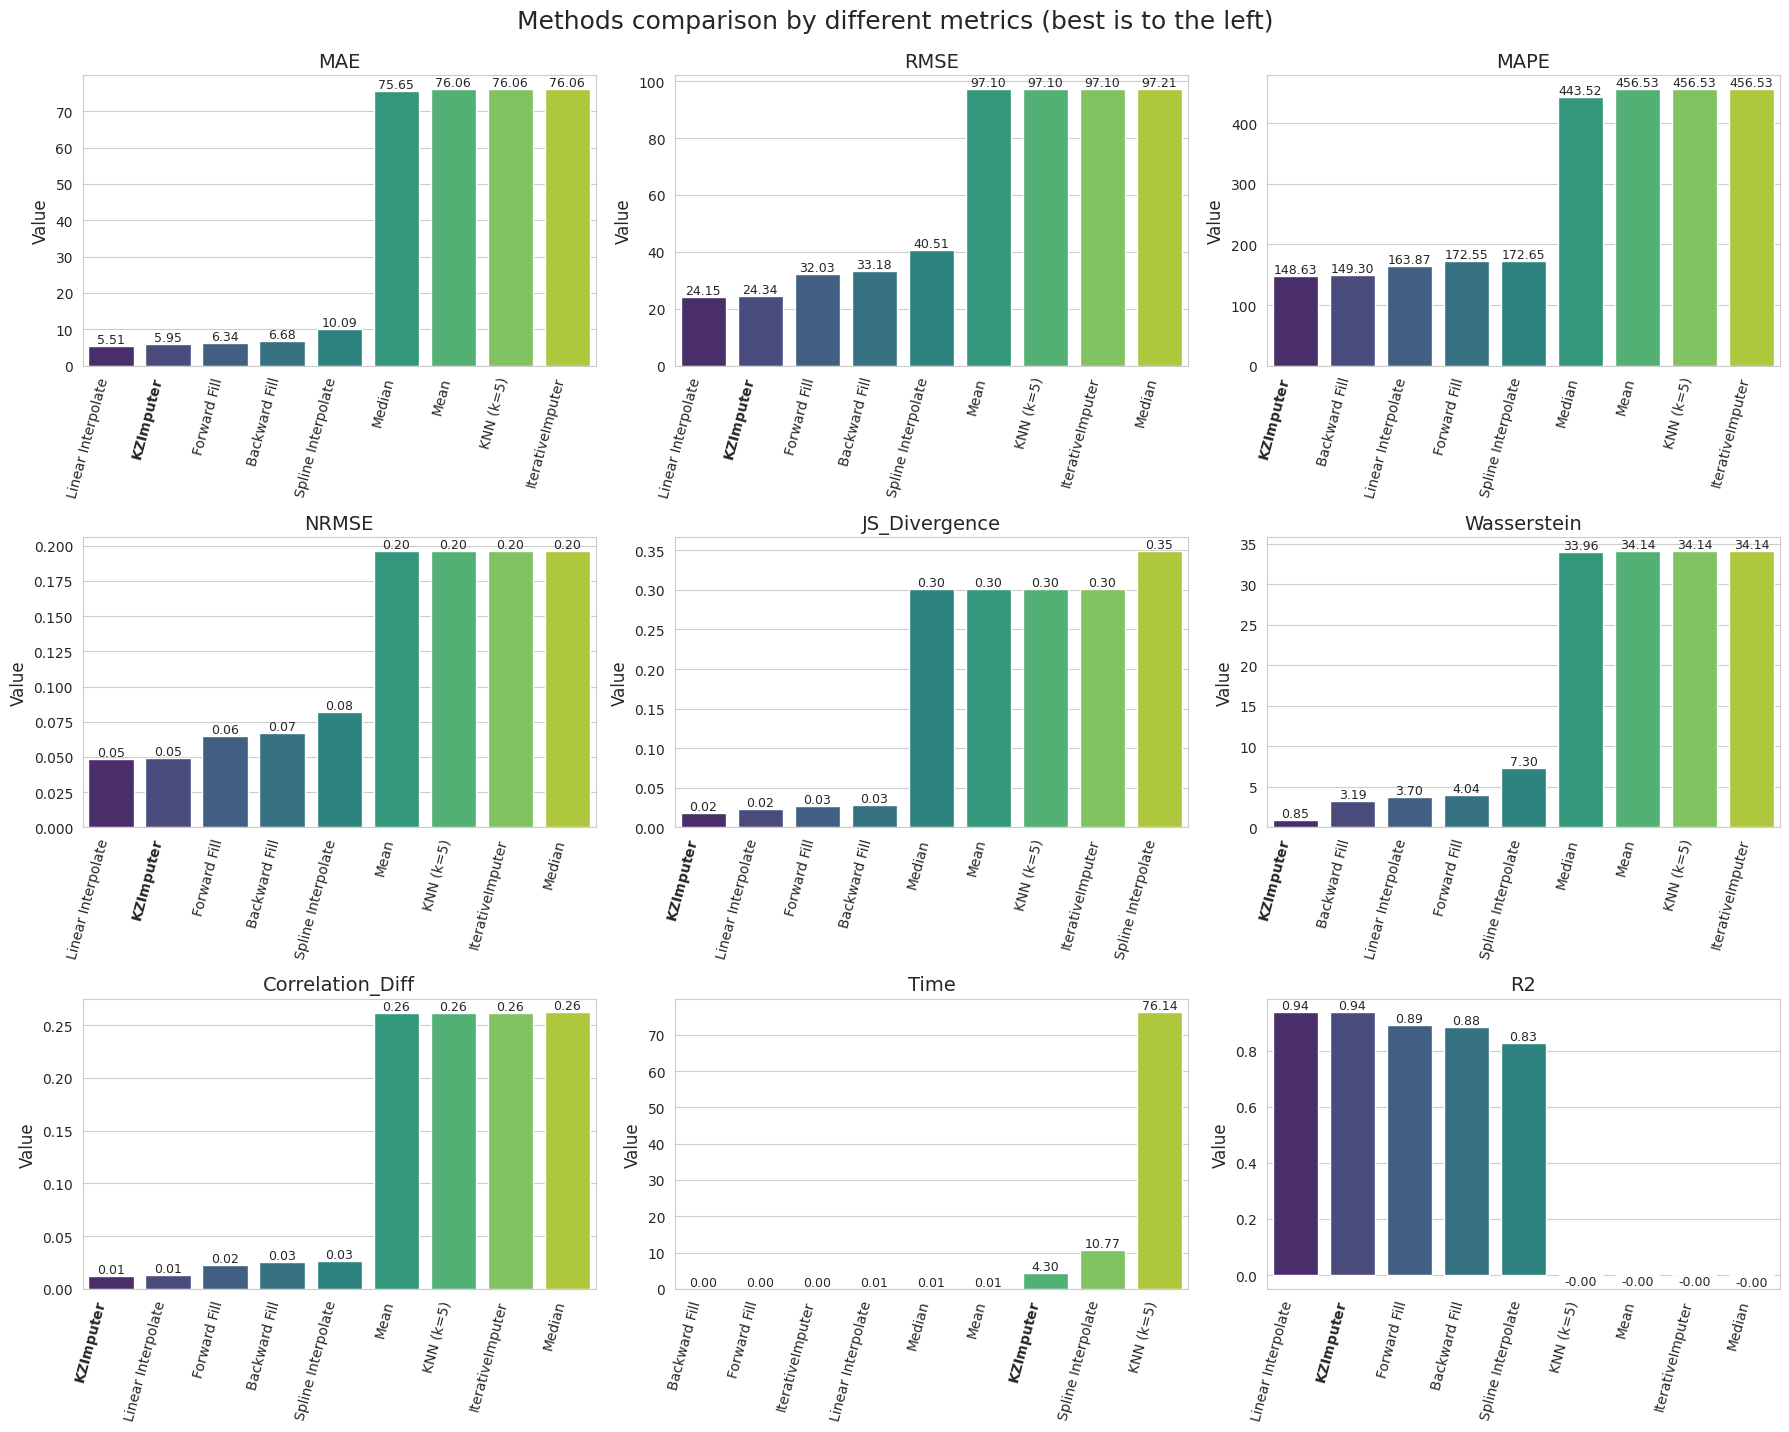

In [27]:
fig, axes = plt.subplots(3, 3, figsize = (18, 14))
axes = axes.flatten()

for i, metric in enumerate(all_metrics):
    ax = axes[i]
    # transform DataFrame with column "Method" and metric
    metric_df = results_df.reset_index()[['Method', metric]].copy()

    # sorting
    ascending = metric in minimize_metrics
    metric_df = metric_df.sort_values(by=metric, ascending=ascending)

    # highlight KZImputer (bold font)
    def format_label(method):
        return f"$\\bf{{{method}}}$" if method == "KZImputer" else method

    formatted_labels = [format_label(m) for m in metric_df['Method']]

    sns.barplot(
        data = metric_df,
        x = 'Method',
        y = metric,
        hue = 'Method',
        palette = 'viridis',
        legend = False,
        ax = ax
    )

    ax.set_title(metric, fontsize = 14)
    ax.set_ylabel('Value', fontsize = 12)
    ax.set_xlabel('')
    ax.set_xticks(range(len(formatted_labels)))
    ax.set_xticklabels(formatted_labels, rotation = 75, ha = 'right')

    for container in ax.containers:
        ax.bar_label(container, fmt = '%.2f', fontsize = 9)

if len(all_metrics) < len(axes):
    for j in range(len(all_metrics), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Methods comparison by different metrics (best is to the left)", fontsize = 18, y = 1.02)
plt.show()

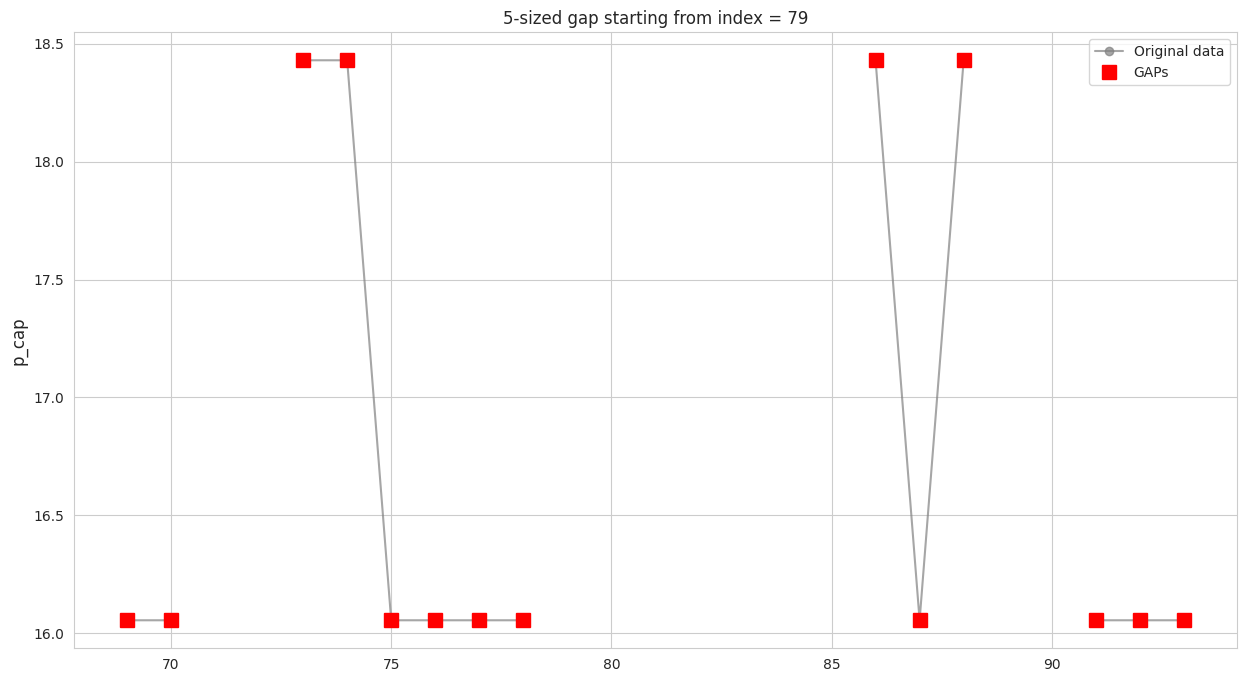

In [28]:
window_size = 5
rolling_na = test_series.isna().rolling(window_size).sum()
clean_slice = test_series.copy()
# indexes
gaps = rolling_na[rolling_na == window_size]

if gaps.empty:
    raise ValueError(f"❌ Did not find any block with {window_size}-sized consecutive missing values.")

gap_start = gaps.index[0]
gap_start_index = test_series.index.get_loc(gap_start) - (window_size - 1)

# slice arround gap
plot_slice = slice(max(0, gap_start_index - 10), min(len(test_series), gap_start_index + 15))

plt.figure(figsize = (15, 8))
plt.plot(clean_slice.iloc[plot_slice], 'o-', label = 'Original data', color = 'gray', alpha = 0.7)
plt.plot(test_series.iloc[plot_slice], 's', markersize = 10, label = 'GAPs', color = 'red')
plt.title(f'{window_size}-sized gap starting from index = {gap_start_index}')
plt.ylabel(research_name_col, fontsize = 12)
plt.legend()
plt.grid(True)
plt.show()

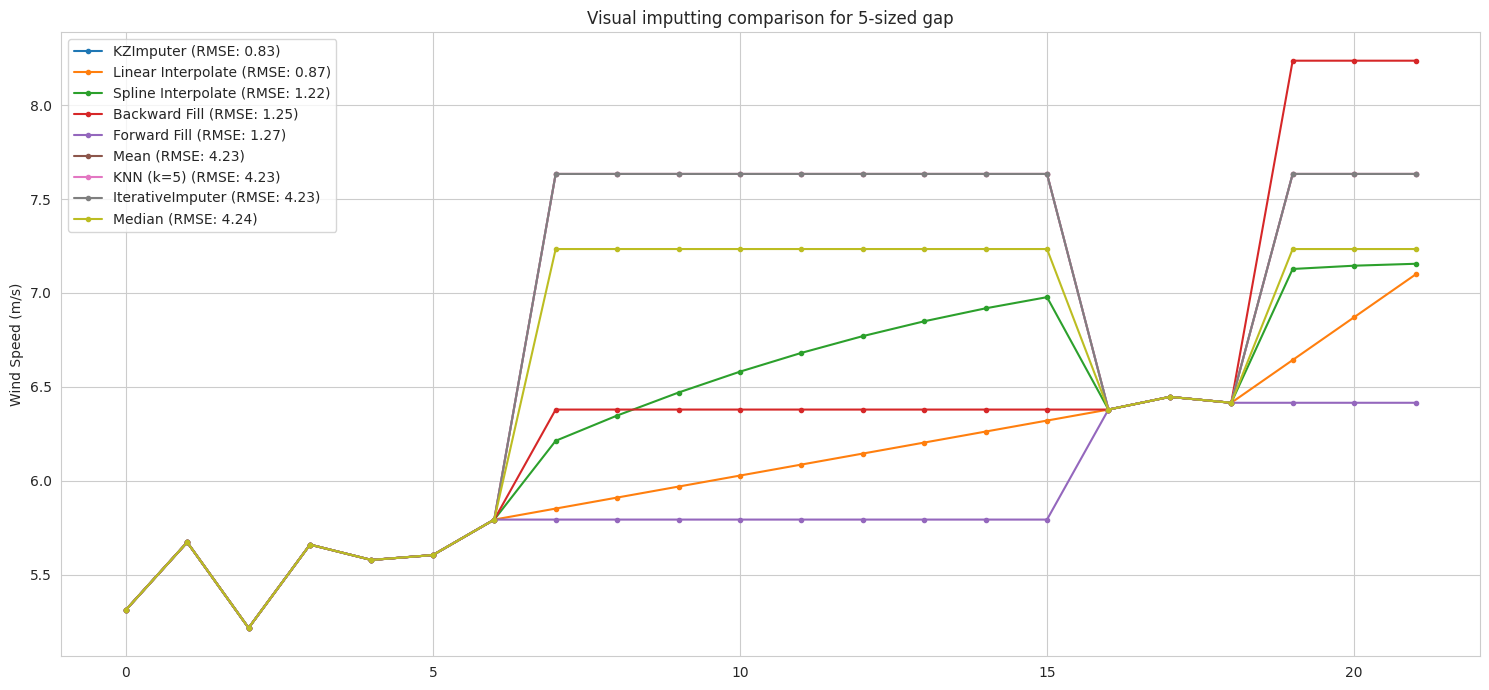

In [ ]:
best_methods = results_df.sort_values('RMSE').index

max_gap = 5
for name in best_methods:
    if isinstance(imputers[name], str):
        if name == "Linear Interpolate":
            imputed = test_series.interpolate(method = 'linear')
        elif name == "Spline Interpolate":
            imputed = test_series.interpolate(method = 'spline', order = 3)
        else:
            if imputers[name] == 'ffill':
                imputed = test_series.ffill()
            elif imputers[name] == 'bfill':
                imputed = test_series.bfill()
            else:
                raise ValueError(f"Unknown imputting method: {imputers[name]}")
    elif name == "KZImputer":
        kz = KZImputer(max_gap_size = max_gap)
        imputed = kz.transform(test_series)
    else:
        imputed_data = imputers[name].fit_transform(test_series.to_frame())
        imputed = pd.Series(imputed_data.flatten(), index=test_series.index)

    plt.plot(imputed.iloc[plot_slice], '.-', label = f'{name} (RMSE: {results_df.loc[name, "RMSE"]:.2f})')

plt.title(f'Visual imputting comparison for {max_gap}-sized gap')
plt.legend()
plt.ylabel(research_name_col)
plt.grid(True)
plt.tight_layout()
plt.show()

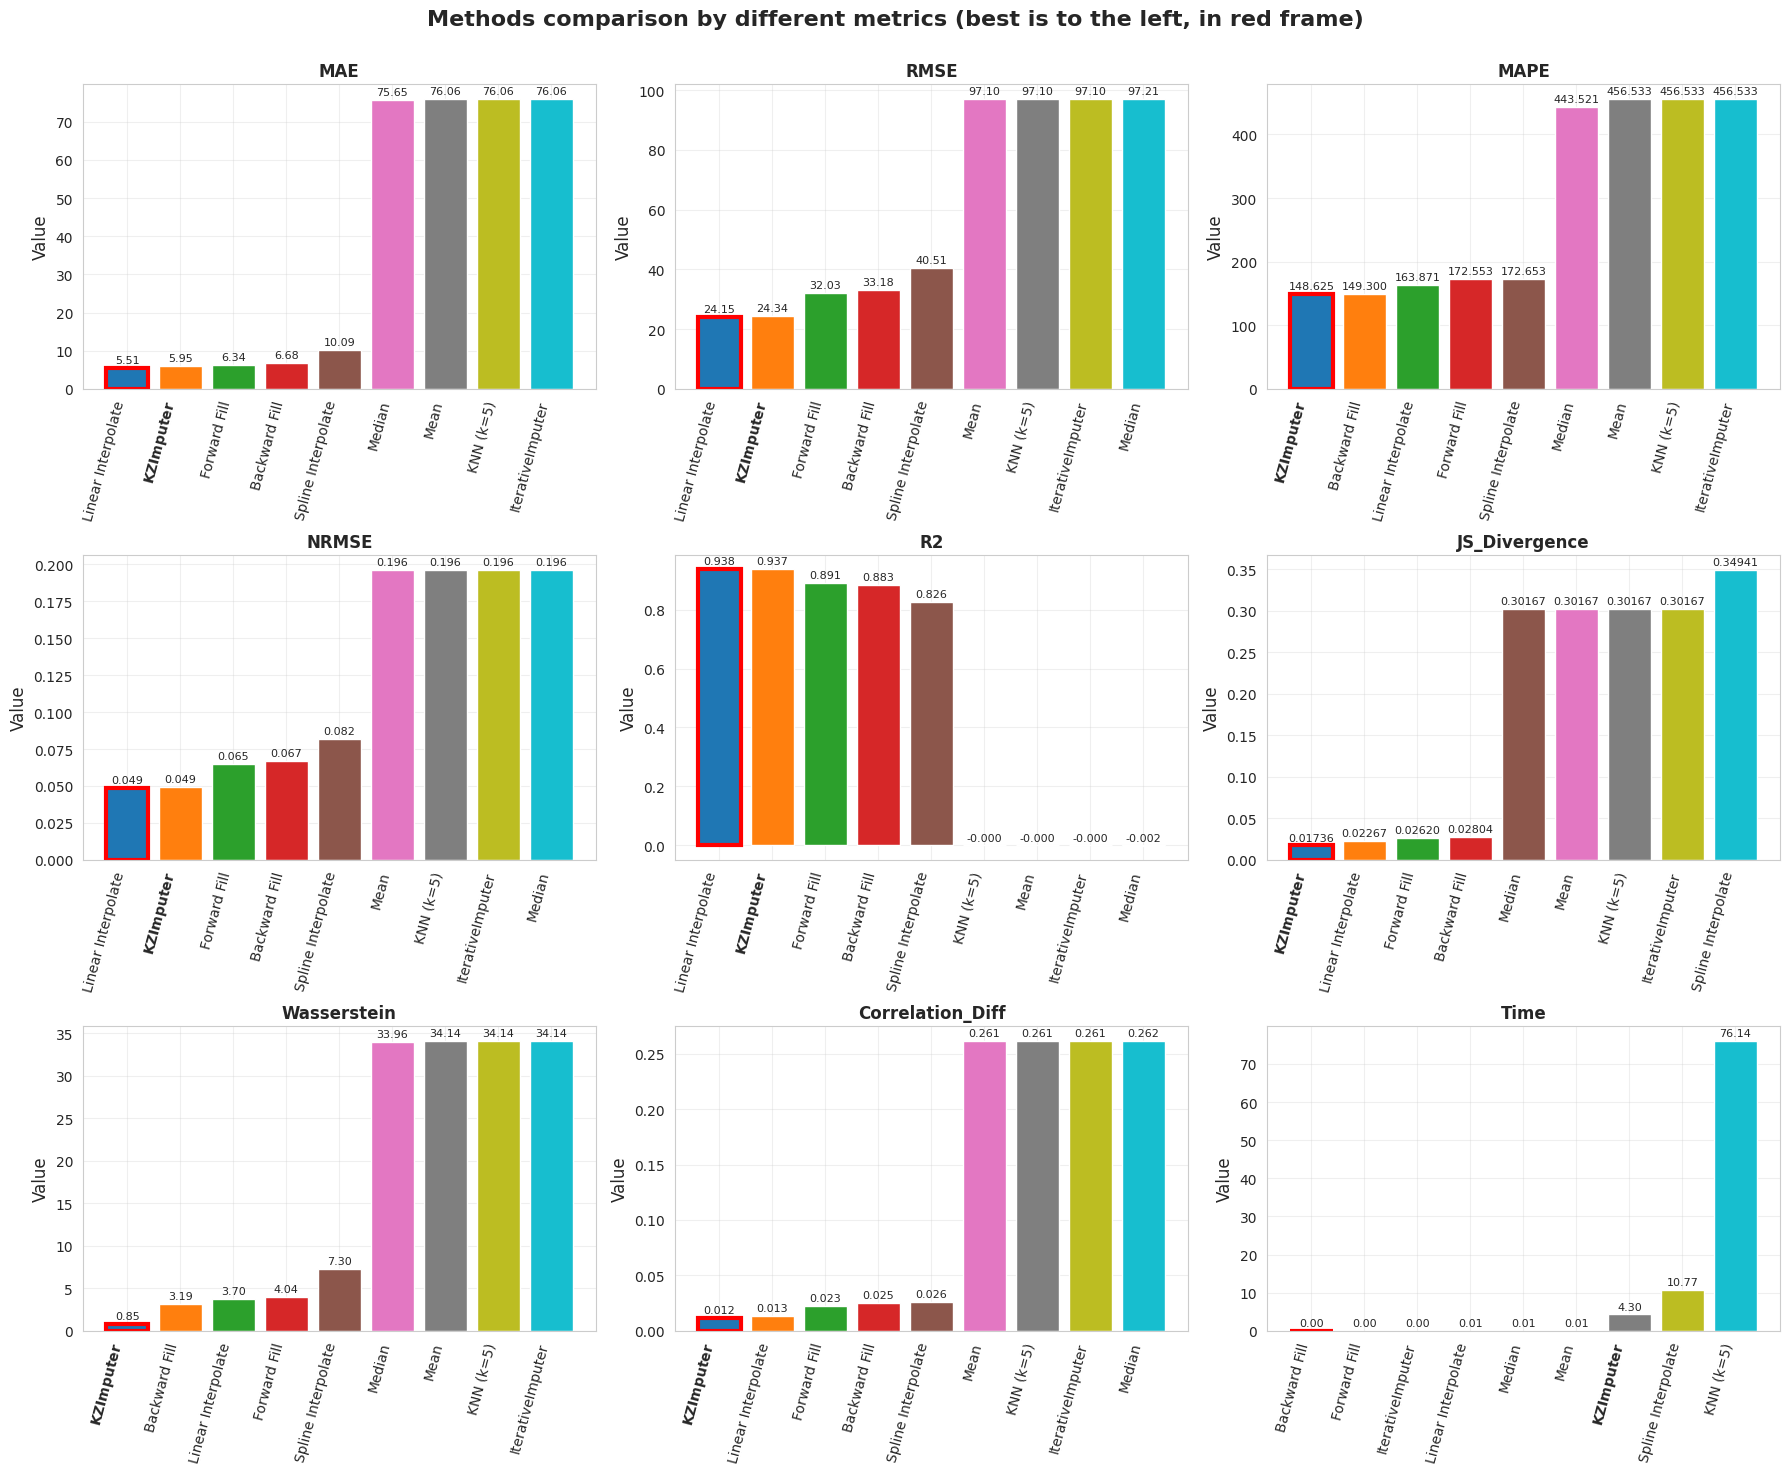

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

# Получите список всех методов из results_df
all_methods = results_df.index.tolist()
colors = plt.cm.tab10(np.linspace(0, 1, len(all_methods)))

def format_label(method):
    return f"$\\bf{{{method}}}$" if method == "KZImputer" else method

for idx, metric in enumerate(all_main_metrics):
    ax = axes[idx]

    # Создайте DataFrame для текущей метрики
    metric_df = results_df.reset_index()[['Method', metric]].copy()

    # Сортировка по текущей метрике
    ascending = metric in minimize_metrics
    metric_df = metric_df.sort_values(by=metric, ascending=ascending)

    # Получите отсортированные значения и методы
    sorted_methods = metric_df['Method'].tolist()
    sorted_values = metric_df[metric].tolist()

    # Форматируйте labels для отсортированных методов
    formatted_labels = [format_label(m) for m in sorted_methods]

    # Постройте график с правильными данными
    bars = ax.bar(range(len(formatted_labels)), sorted_values, color=colors[:len(sorted_values)])

    ax.set_xticks(range(len(formatted_labels)))
    ax.set_xticklabels(formatted_labels, rotation=75, ha='right', fontsize=10)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Добавьте значения на столбцы
    for i, (bar, value) in enumerate(zip(bars, sorted_values)):
        if not np.isnan(value):
            if metric in ['MAPE', 'R2', 'NRMSE', 'Correlation_Diff']:
                text = f'{value:.3f}'
            elif metric == 'JS_Divergence':  # Исправлено: убрал список
                text = f'{value:.5f}'
            elif metric in ['MAE', 'RMSE', 'Wasserstein']:
                text = f'{value:.0f}' if value > 1000 else f'{value:.2f}'
            else:
                text = f'{value:.2e}' if abs(value) > 1e6 else f'{value:.2f}'

            ax.text(bar.get_x() + bar.get_width()/2,
                   bar.get_height() + 0.01*max([v for v in sorted_values if not np.isnan(v)]),
                   text, ha='center', va='bottom', fontsize=8, rotation=0)

    # Выделите лучший результат (первый в отсортированном списке)
    if len(bars) > 0:
        bars[0].set_edgecolor('red')
        bars[0].set_linewidth(3)

# Если у вас только 8 метрик, скройте 9-й subplot
if len(all_main_metrics) < 9:
    axes[len(all_main_metrics)].set_visible(False)

plt.suptitle('Methods comparison by different metrics (best is to the left, in red frame)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

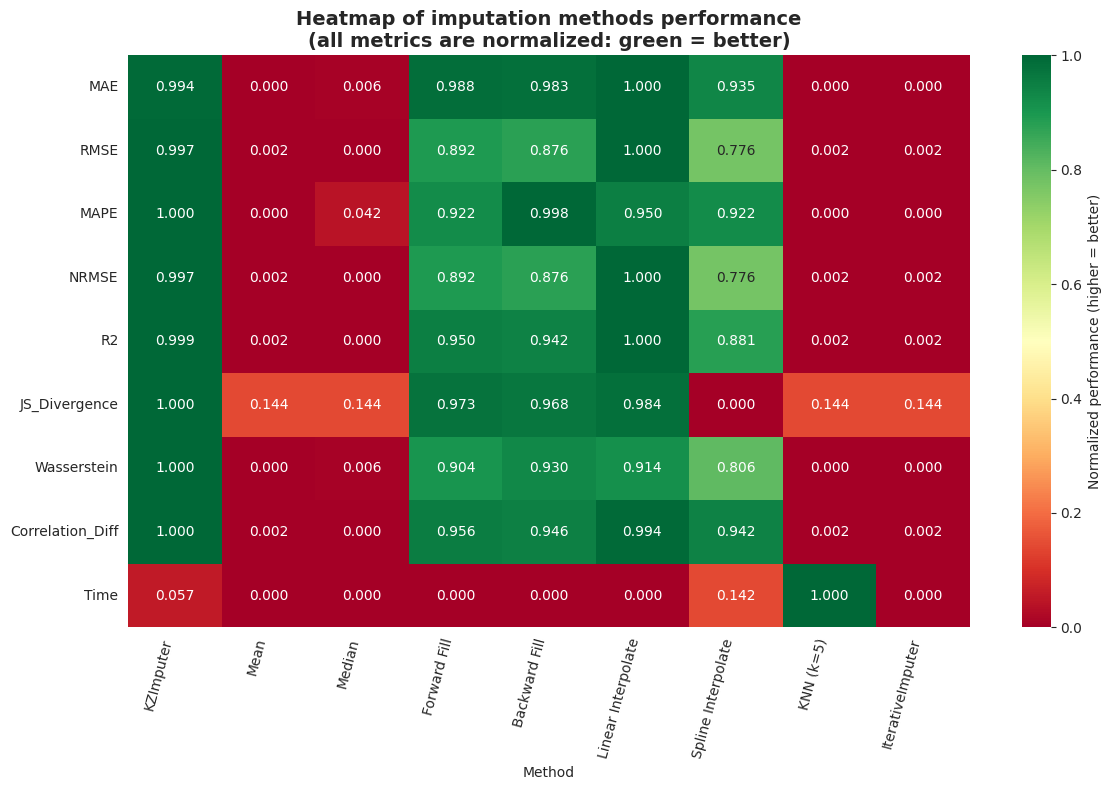

In [30]:
# Extra: Create a heat map for better visibility
plt.figure(figsize=(12, 8))

# Normalize data for heat map (0-1 scale for each metric)
normalized_data = results_df[all_main_metrics].copy()
for metric in all_main_metrics:
    if metric in minimize_metrics[:-1]:
        normalized_data[metric] = 1 - (normalized_data[metric] - normalized_data[metric].min()) / (normalized_data[metric].max() - normalized_data[metric].min())
    else:
        normalized_data[metric] = (normalized_data[metric] - normalized_data[metric].min()) / (normalized_data[metric].max() - normalized_data[metric].min())

# create heatmap
sns.heatmap(normalized_data.T,
           annot=True,
           fmt='.3f',
           cmap='RdYlGn',
           xticklabels=results_df.index,
           yticklabels=all_main_metrics,
           cbar_kws={'label': 'Normalized performance (higher = better)'})

plt.title('Heatmap of imputation methods performance\n(all metrics are normalized: green = better)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=75, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

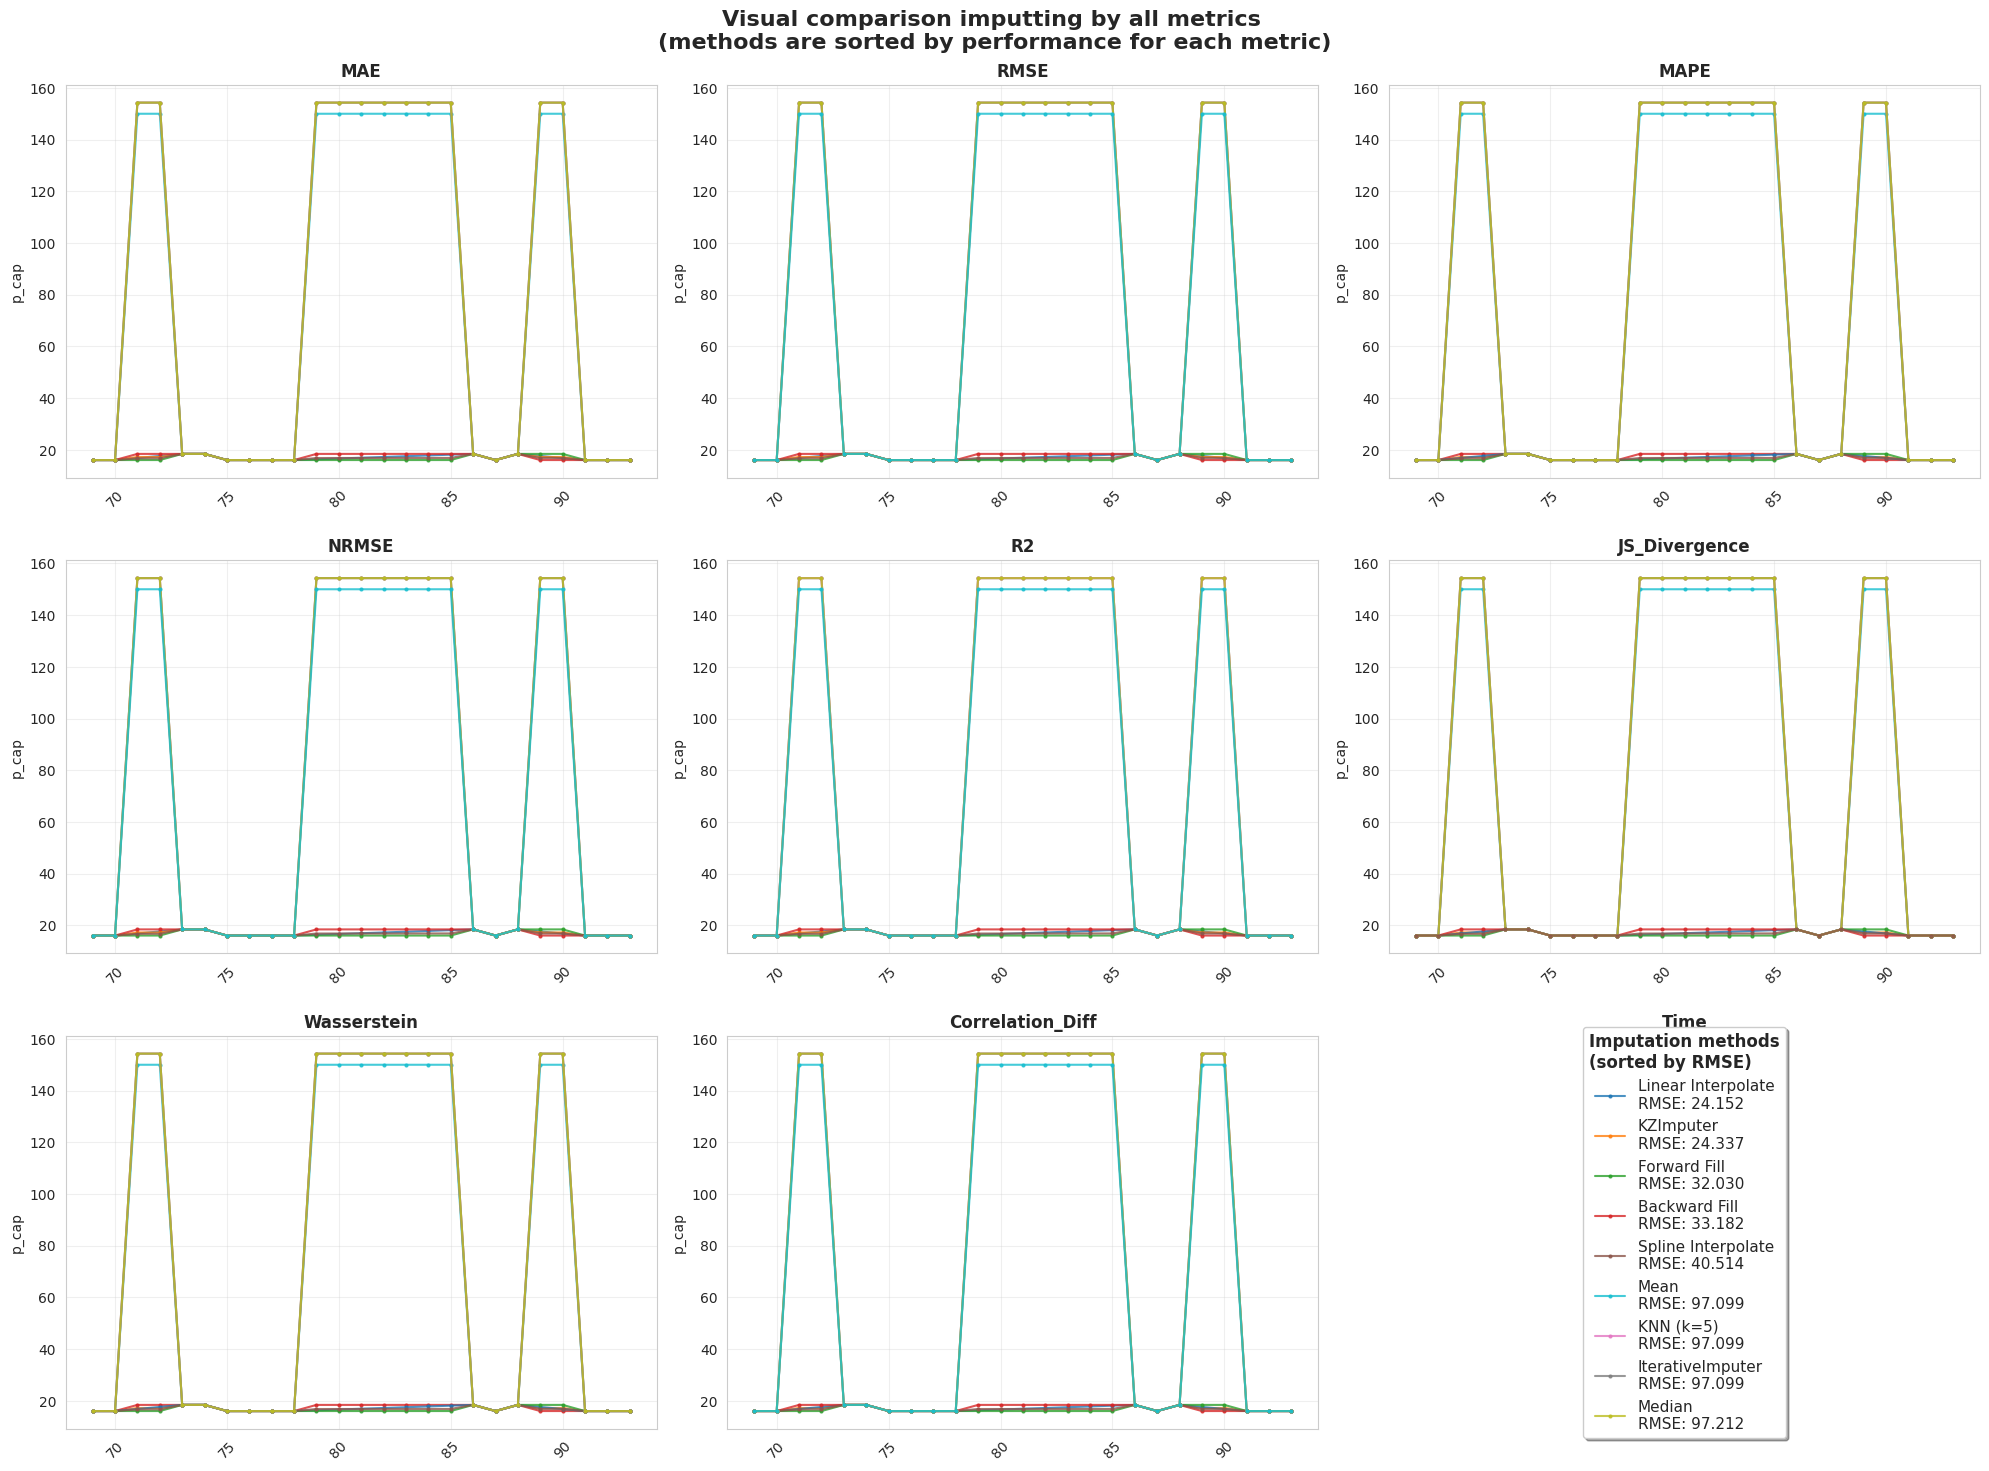

In [32]:
# create grid 3x3
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()
best_methods = results_df.sort_values('RMSE').index
# colors for methods
colors = plt.cm.tab10(np.linspace(0, 1, len(best_methods)))
color_dict = {method: colors[i] for i, method in enumerate(best_methods)}

legend_handles = []
legend_labels = []

for idx, metric in enumerate(all_main_metrics):
    ax = axes[idx]

    if metric in minimize_metrics[:-1]:
        sorted_methods = results_df.sort_values(metric).index
    else:
        # for R2
        sorted_methods = results_df.sort_values(metric, ascending=False).index

    for i, name in enumerate(sorted_methods):
        if isinstance(imputers[name], str):
            if name == "Linear Interpolate":
                imputed = test_series.interpolate(method='linear')
            elif name == "Spline Interpolate":
                imputed = test_series.interpolate(method='spline', order=3)
            else:
                if imputers[name] == 'ffill':
                    imputed = test_series.ffill()
                elif imputers[name] == 'bfill':
                    imputed = test_series.bfill()
                else:
                    raise ValueError(f"Unknown imputting method: {imputers[name]}")
        elif name == "KZImputer":
            kz = KZImputer(max_gap_size=5)
            imputed = kz.transform(test_series)
        else:

            imputed_data = imputers[name].fit_transform(test_series.to_frame())
            imputed = pd.Series(imputed_data.flatten(), index=test_series.index)


        line = ax.plot(imputed.iloc[plot_slice], '.-',
                      color=color_dict[name],
                      alpha=0.8, linewidth=1.5, markersize=4)


        if idx == 0:
            legend_handles.append(line[0])
            legend_labels.append(f'{name}')

    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel(research_name_col, fontsize=10)
    ax.grid(True, alpha=0.3)

    ax.tick_params(axis='x', rotation=45)

# set 9-th subplot as legend
legend_ax = axes[8]
legend_ax.set_xlim(0, 1)
legend_ax.set_ylim(0, 1)
legend_ax.axis('off')

# create separated legend
legend_text = []
for method in best_methods:
    metrics_str = f"RMSE: {results_df.loc[method, 'RMSE']:.3f}"
    legend_text.append(f"{method}\n{metrics_str}")

# Размещаем легенду
legend = legend_ax.legend(legend_handles, legend_text,
                         loc='center',
                         fontsize=11,
                         title='Imputation methods\n(sorted by RMSE)',
                         title_fontsize=12,
                         frameon=True,
                         fancybox=True,
                         shadow=True,
                         ncol=1)

legend.get_title().set_fontweight('bold')

plt.suptitle('Visual comparison imputting by all metrics \n(methods are sorted by performance for each metric)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# research based on another DS

In [ ]:
def run_imputation_experiment(data_path, target_column, date_column=None, date_format=None, **kwargs):
    """
    Проводит полный эксперимент по сравнению методов импутации на заданном датасете.

    Параметры:
        data_path (str): Путь к CSV файлу.
        target_column (str): Название колонки с временным рядом.
        date_column (str, optional): Название колонки с датой/временем.
        date_format (str, optional): Формат даты для pd.to_datetime.
        **kwargs: Дополнительные аргументы для pd.read_csv (например, sep=',').
    """
    print(f"--- Запуск эксперимента для датасета: {data_path.split('/')[-1]} ---")

    # 1. Загрузка и подготовка данных
    df = pd.read_csv(data_path, **kwargs)

    if date_column:
        df[date_column] = pd.to_datetime(df[date_column], format=date_format)
        df = df.set_index(date_column)

    # Выбираем целевую колонку
    series = df[target_column].astype(float)

    # Обработка уже существующих пропусков (для чистоты эксперимента)
    series = series.dropna()

    if len(series) < 100:
        print("Датасет слишком короткий, пропускаем.")
        return None

    # 2. Создание искусственных пропусков
    np.random.seed(42)
    test_series = series.copy()

    # Масштабируем количество пропусков к размеру датасета
    num_single_gaps = max(10, int(len(test_series) * 0.01))
    num_triple_gaps = max(3, int(len(test_series) * 0.005))
    num_penta_gaps = max(2, int(len(test_series) * 0.003))

    for _ in range(num_single_gaps):
        idx = np.random.randint(10, len(test_series) - 10)
        test_series.iloc[idx] = np.nan
    for _ in range(num_triple_gaps):
        idx = np.random.randint(10, len(test_series) - 15)
        test_series.iloc[idx:idx+3] = np.nan
    for _ in range(num_penta_gaps):
        idx = np.random.randint(10, len(test_series) - 20)
        test_series.iloc[idx:idx+5] = np.nan

    missing_indices = test_series.isna()
    print(f"Внесено {missing_indices.sum()} пропусков ({missing_indices.sum()/len(series):.2%}).")

    # 3. Сравнение методов импутации
    imputers = {
        "KZImputer": KZImputer(max_gap_size=5),
        "Mean": SimpleImputer(strategy='mean'),
        "Median": SimpleImputer(strategy='median'),
        "Forward Fill": 'ffill',
        "Backward Fill": 'bfill',
        "Linear Interpolate": 'linear',
        "Spline Interpolate": 'spline',
        "KNN (k=5)": KNNImputer(n_neighbors=5),
        "IterativeImputer": IterativeImputer(max_iter=10, random_state=0)
    }

    results = []

    # For imputers that need a 2D array, we transform the data
    test_series_2d = test_series.to_frame()

    for name, imputer in imputers.items():
        start_time = time.time()

        if isinstance(imputer, str):
            if name == "Linear Interpolate":
                imputed_series = test_series.interpolate(method = "linear")
            elif name == "Spline Interpolate":
                imputed_series = test_series.interpolate(method = "spline", order = 3)
            elif name == "Forward Fill":
                imputed_series = test_series.ffill()
            elif name == "Backward Fill":
                imputed_series = test_series.bfill()
        elif name == "KZImputer":
            imputed_series = imputer.transform(test_series)
        else:
            imputed_data = imputer.fit_transform(test_series_2d)
            imputed_series = pd.Series(imputed_data.flatten(), index = test_series.index)

        elapsed = time.time() - start_time

        metrics = evaluate_metrics(
            true_values = clean_slice[missing_indices],
            imputed_values = imputed_series[missing_indices],
            full_true = clean_slice,
            full_imputed = imputed_series
        )
        metrics["Time (s)"] = elapsed
        metrics["Method"] = name
        results.append(metrics)

    results_df = pd.DataFrame(results).set_index("Method")
    results_df = results_df[[
        "MAE", "RMSE", "MAPE", "R2", "NRMSE",
        "JS_Divergence", "Wasserstein", "Correlation_Diff",
        "Time (s)"
    ]]

    return results_df